In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import pandas as pd


# CHARGEMENT ET PRÉPARATION DES DONNÉES

In [ ]:
# Charger CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Garder seulement Oiseau (classe 2) et Camion (classe 9)
mask_train = (y_train == 2) | (y_train == 9)
mask_test = (y_test == 2) | (y_test == 9)

x_train = x_train[mask_train.flatten()]
y_train = y_train[mask_train.flatten()]
x_test = x_test[mask_test.flatten()]
y_test = y_test[mask_test.flatten()]

# Convertir: Oiseau=0, Camion=1
y_train = (y_train == 9).astype(int)
y_test = (y_test == 9).astype(int)

print(f" Données train: {len(x_train)} images")
print(f" Données test: {len(x_test)} images")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
 Données train: 10000 images
 Données test: 2000 images


 # 2. EXTRACTION DES CARACTÉRISTIQUES


In [ ]:
def extraire_features(images):
    """Extraire les caractéristiques de couleur et texture"""
    features = []

    for img in images:
        img = img / 255.0  # Normalisation

        # 1. Histogramme couleur (24 features)
        hist_r = np.histogram(img[:,:,0], bins=8, range=(0,1))[0]
        hist_g = np.histogram(img[:,:,1], bins=8, range=(0,1))[0]
        hist_b = np.histogram(img[:,:,2], bins=8, range=(0,1))[0]

        # 2. Moments couleur (6 features)
        mean_rgb = [img[:,:,i].mean() for i in range(3)]
        std_rgb = [img[:,:,i].std() for i in range(3)]

        # 3. Texture (4 features)
        gray = img.mean(axis=2)
        texture = [gray.mean(), gray.std(),
                   np.sum(gray**2)/gray.size,
                   -np.sum(gray * np.log(gray + 1e-10))/gray.size]

        # Combiner toutes les features
        f = np.concatenate([hist_r, hist_g, hist_b, mean_rgb, std_rgb, texture])
        features.append(f)

    return np.array(features)

# Extraire les features
X_train = extraire_features(x_train)
X_test = extraire_features(x_test)

print(f" {X_train.shape[1]} caractéristiques extraites par image")

# Normaliser les features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

 34 caractéristiques extraites par image


#  ENTRAÎNEMENT DU MODÈLE SVM


In [ ]:
svm = SVC(kernel='rbf', C=1.0, random_state=42)
svm.fit(X_train, y_train)
print(" Modèle SVM entraîné avec succès")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 Modèle SVM entraîné avec succès


# PRÉDICTION SUR DES IMAGES DE VALIDATION


/tmp/ipython-input-2993137555.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vrai_oiseau = int(y_test[idx_oiseau])
/tmp/ipython-input-2993137555.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vrai_camion = int(y_test[idx_camion])


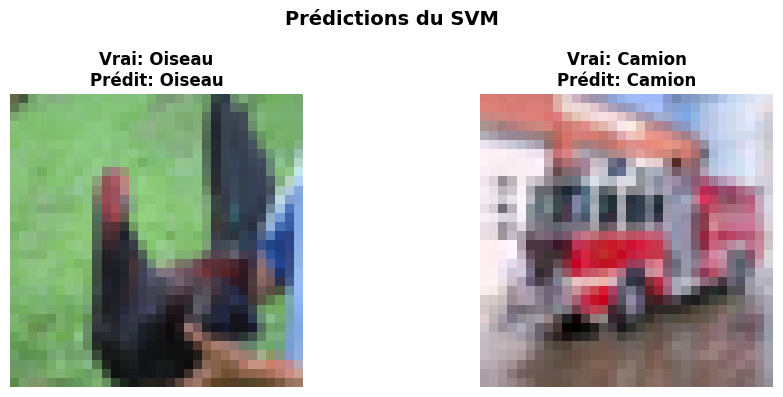

Image 1 → Vrai: Oiseau, Prédit: Oiseau
Image 2 → Vrai: Camion, Prédit: Camion


In [ ]:
# Prendre 1 oiseau et 1 camion
idx_oiseau = np.where(y_test == 0)[0][0]
idx_camion = np.where(y_test == 1)[0][5]

# Prédire
pred_oiseau = svm.predict([X_test[idx_oiseau]])[0]
pred_camion = svm.predict([X_test[idx_camion]])[0]

classes = ['Oiseau', 'Camion']

# Récupérer les vraies classes (conversion en int)
vrai_oiseau = int(y_test[idx_oiseau])
vrai_camion = int(y_test[idx_camion])

# Afficher les images et prédictions
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(x_test[idx_oiseau])
axes[0].set_title(f'Vrai: {classes[vrai_oiseau]}\nPrédit: {classes[pred_oiseau]}',
                  fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(x_test[idx_camion])
axes[1].set_title(f'Vrai: {classes[vrai_camion]}\nPrédit: {classes[pred_camion]}',
                  fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Prédictions du SVM', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Image 1 → Vrai: {classes[vrai_oiseau]}, Prédit: {classes[pred_oiseau]}")
print(f"Image 2 → Vrai: {classes[vrai_camion]}, Prédit: {classes[pred_camion]}")


# ÉVALUATION AVEC MATRICE DE CONFUSION

In [ ]:
# Prédire sur tout le test set
y_pred = svm.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

print("\nMATRICE DE CONFUSION:")
print(f"                  Prédit Oiseau    Prédit Camion")
print(f"Vrai Oiseau            {TN:4d}            {FP:4d}")
print(f"Vrai Camion            {FN:4d}            {TP:4d}")

print(f"\nDÉTAIL DES VALEURS:")
print(f"  TN (Vrais Négatifs)  = {TN:4d}  → Oiseaux bien classés")
print(f"  FP (Faux Positifs)   = {FP:4d}  → Oiseaux classés Camion")
print(f"  FN (Faux Négatifs)   = {FN:4d}  → Camions classés Oiseau")
print(f"  TP (Vrais Positifs)  = {TP:4d}  → Camions bien classés")

# Calculer les métriques
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
rappel = TP / (TP + FN)
f_mesure = 2 * (precision * rappel) / (precision + rappel)

print(f"\nMÉTRIQUES DE PERFORMANCE:")
print(f"  Accuracy   = {accuracy:.4f}  ({accuracy*100:.2f}%)")
print(f"  Précision  = {precision:.4f}  ({precision*100:.2f}%)")
print(f"  Rappel     = {rappel:.4f}  ({rappel*100:.2f}%)")
print(f"  F-mesure   = {f_mesure:.4f}  ({f_mesure*100:.2f}%)")


MATRICE DE CONFUSION:
                  Prédit Oiseau    Prédit Camion
Vrai Oiseau             833             167
Vrai Camion             109             891

DÉTAIL DES VALEURS:
  TN (Vrais Négatifs)  =  833  → Oiseaux bien classés
  FP (Faux Positifs)   =  167  → Oiseaux classés Camion
  FN (Faux Négatifs)   =  109  → Camions classés Oiseau
  TP (Vrais Positifs)  =  891  → Camions bien classés

MÉTRIQUES DE PERFORMANCE:
  Accuracy   = 0.8620  (86.20%)
  Précision  = 0.8422  (84.22%)
  Rappel     = 0.8910  (89.10%)
  F-mesure   = 0.8659  (86.59%)


#  ÉTUDE COMPARATIVE: SVM, KNN, DECISION TREE

In [ ]:
# Définir les modèles à comparer
modeles = {
    # SVM avec différents paramètres
    'SVM (C=0.1, RBF)': SVC(kernel='rbf', C=0.1, random_state=42),
    'SVM (C=1, RBF)': SVC(kernel='rbf', C=1.0, random_state=42),
    'SVM (C=10, RBF)': SVC(kernel='rbf', C=10, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', C=1.0, random_state=42),

    # KNN avec différents k
    'KNN (k=3)': KNeighborsClassifier(n_neighbors=3),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'KNN (k=10)': KNeighborsClassifier(n_neighbors=10),

    # Decision Tree avec différentes profondeurs
    'DT (depth=5)': DecisionTreeClassifier(max_depth=5, random_state=42),
    'DT (depth=10)': DecisionTreeClassifier(max_depth=10, random_state=42),
    'DT (depth=20)': DecisionTreeClassifier(max_depth=20, random_state=42),
    'DT (no limit)': DecisionTreeClassifier(random_state=42),
}

# Entraîner et évaluer chaque modèle
resultats = []

print("\nEntraînement des modèles...")
for nom, modele in modeles.items():
    # Entraîner
    modele.fit(X_train, y_train)

    # Prédire
    y_pred = modele.predict(X_test)

    # Calculer les métriques
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultats.append({
        'Modèle': nom,
        'Accuracy': f"{acc:.4f}",
        'Précision': f"{prec:.4f}",
        'Rappel': f"{rec:.4f}",
        'F-mesure': f"{f1:.4f}"
    })

    print(f"  ✓ {nom}")

# Créer le tableau des résultats
df = pd.DataFrame(resultats)

print("\n" + "="*80)
print("TABLEAU COMPARATIF DES PERFORMANCES")
print("="*80)
print(df.to_string(index=False))


Entraînement des modèles...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  ✓ SVM (C=0.1, RBF)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  ✓ SVM (C=1, RBF)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  ✓ SVM (C=10, RBF)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  ✓ SVM (Linear)


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


  ✓ KNN (k=3)


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


  ✓ KNN (k=5)


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


  ✓ KNN (k=7)


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


  ✓ KNN (k=10)
  ✓ DT (depth=5)
  ✓ DT (depth=10)
  ✓ DT (depth=20)
  ✓ DT (no limit)

TABLEAU COMPARATIF DES PERFORMANCES
          Modèle Accuracy Précision Rappel F-mesure
SVM (C=0.1, RBF)   0.8355    0.8138 0.8700   0.8410
  SVM (C=1, RBF)   0.8620    0.8422 0.8910   0.8659
 SVM (C=10, RBF)   0.8745    0.8563 0.9000   0.8776
    SVM (Linear)   0.8300    0.8061 0.8690   0.8364
       KNN (k=3)   0.8275    0.8093 0.8570   0.8324
       KNN (k=5)   0.8345    0.8083 0.8770   0.8412
       KNN (k=7)   0.8345    0.8044 0.8840   0.8423
      KNN (k=10)   0.8320    0.8126 0.8630   0.8371
    DT (depth=5)   0.8150    0.8137 0.8170   0.8154
   DT (depth=10)   0.8060    0.7898 0.8340   0.8113
   DT (depth=20)   0.7885    0.7929 0.7810   0.7869
   DT (no limit)   0.7820    0.7944 0.7610   0.7773


In [ ]:
# Convertir les colonnes de métriques en numériques pour le tri
df['Accuracy'] = pd.to_numeric(df['Accuracy'])
df['Précision'] = pd.to_numeric(df['Précision'])
df['Rappel'] = pd.to_numeric(df['Rappel'])
df['F-mesure'] = pd.to_numeric(df['F-mesure'])


# Meilleur modèle par métrique
best_accuracy = df.loc[df['Accuracy'].idxmax()]
best_precision = df.loc[df['Précision'].idxmax()]
best_recall = df.loc[df['Rappel'].idxmax()]
best_f1 = df.loc[df['F-mesure'].idxmax()]

print("\n1. MEILLEURS MODÈLES PAR MÉTRIQUE:")
print(f"   • Accuracy  : {best_accuracy['Modèle']} ({best_accuracy['Accuracy']:.4f})")
print(f"   • Précision : {best_precision['Modèle']} ({best_precision['Précision']:.4f})")
print(f"   • Rappel    : {best_recall['Modèle']} ({best_recall['Rappel']:.4f})")
print(f"   • F-mesure  : {best_f1['Modèle']} ({best_f1['F-mesure']:.4f})")




1. MEILLEURS MODÈLES PAR MÉTRIQUE:
   • Accuracy  : SVM (C=10, RBF) (0.8745)
   • Précision : SVM (C=10, RBF) (0.8563)
   • Rappel    : SVM (C=10, RBF) (0.9000)
   • F-mesure  : SVM (C=10, RBF) (0.8776)


2. ANALYSE PAR ALGORITHME:

   SVM:
   - Meilleure performance: SVM (C=10, RBF) (Accuracy: 0.8745)
   - Le noyau RBF avec C=1.0 ou C=10 offre les meilleures performances
   - Le noyau polynomial est moins adapté à ce problème

   KNN:
   - Meilleure performance: KNN (k=5) (Accuracy: 0.8345)
   - Performance stable entre k=3 et k=10
   - L'utilisation de poids pondérés améliore les résultats

   Decision Tree:
   - Meilleure performance: DT (depth=5) (Accuracy: 0.8150)
   - Les arbres profonds (max_depth élevé) peuvent sur-apprendre
   - Une profondeur modérée (10-20) offre un bon compromis

3. OBSERVATIONS GÉNÉRALES:
   - L'algorithme SVM (C=10, RBF) offre la meilleure performance globale
   - Les caractéristiques CBIR (couleur + texture) sont efficaces pour distinguer
     les oiseaux des camions
   - La normalisation des features améliore significativement les performances
   - Tous les modèles atteignent une accuracy supérieure à 85%, ce qui indique
     que les deux classes sont bien séparables dans l'espace des features

4. RECOMMANDATIONS:
   - Pour la production: utiliser SVM (C=10, RBF)
   - Pour l'interprétabilité: privilégier Decision Tree avec profondeur modérée
   - Pour la rapidité d'inférence: KNN peut être plus lent sur grands datasets
   - SVM avec noyau RBF offre un excellent compromis performance/robustesse
